# PIPELINE

This file ingests the preprocessed 

## Libraries

Libraries used in the elaboration of this notebook.

In [2]:
# Standard Libraries
import os
import re
import math
import inspect
from collections import Counter

# Data Ingestion and Manipulation
import json
import numpy as np
import pandas as pd

# Statistics
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer

# Clustering and Outlier Detection
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import silhouette_score, mean_squared_error, pairwise_distances

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

# Data Visualization
import matplotlib.pyplot as plt

# Data Generation
from sklearn.datasets import make_blobs

# Display options for pandas
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)


## Helper Functions and Classes

Functions and Classes used to assist in the various stages of the pipeline.

### General assistance functions

#### summarize_dataframe

Summarizes dataframe values information

In [2]:
def summarize_dataframe(df):
    """
    Provides a detailed summary of all variables in a DataFrame, including unique values,
    value counts, and the total number of unique values.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: A summary DataFrame with columns:
            - variable: Column names in the input DataFrame.
            - dtype: Data types of the columns.
            - unique_count: Number of unique values in each column.
            - unique_values: A sample of unique values for each column.
            - value_counts: Value counts (top 5 values with counts) for each column.
    """
    summary = {
        "variable": [],
        "dtype": [],
        "unique_count": [],
        "unique_values": [],
        "value_counts": []
    }
    
    for col in df.columns:
        summary["variable"].append(col)
        summary["dtype"].append(df[col].dtype)
        summary["unique_count"].append(df[col].nunique())
        summary["unique_values"].append(df[col].unique()[:5])  # Limit to first 5 unique values for readability
        summary["value_counts"].append(df[col].value_counts().head(5).to_dict())  # Top 5 most frequent values
    
    return pd.DataFrame(summary)


#### compare_dataframe_columns

Checks the columns of two dataframes highlighting their differences.

In [4]:
def compare_dataframe_columns(df1, df2):
    """
    Compares the columns of two DataFrames and identifies their intersection, 
    as well as columns unique to each DataFrame.

    Args:
        df1 (pandas.DataFrame): The first DataFrame to compare.
        df2 (pandas.DataFrame): The second DataFrame to compare.

    Returns:
        tuple: A tuple containing:
            - common_columns (pandas.Index): Columns present in both DataFrames.
            - only_in_df1 (set): Columns only in df1.
            - only_in_df2 (set): Columns only in df2.
    """
    common_columns = df1.columns.intersection(df2.columns)

    if len(common_columns) == len(df1.columns) == len(df2.columns):
        print("Both dataframes have the same columns.")
    
    else:
        print("The dataframes do not have the same columns.")
        print("Columns in df1 but not in df2:", set(df1.columns) - set(df2.columns))
        print("Columns in df2 but not in df1:", set(df2.columns) - set(df1.columns))


#### summarize_missing_information

Creates a dataframe with the relevant information regarding missing values.

In [5]:
def summarize_missing_information(df):
    """
    Aggregates information about missing values in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: A summary DataFrame with columns:
            - variable: Column names in the input DataFrame.
            - dtype: Data types of the columns.
            - count: Total number of entries in each column.
            - unique: Number of unique values in each column.
            - missing: Count of missing values in each column.
            - pc_missing: Percentage of missing values in each column.
    """
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])*100)))
        
    output = pd.DataFrame({
    'variable': variables, 
    'dtype': dtypes,
    'count': count,
    'unique': unique,
    'missing': missing, 
    'pc_missing': pc_missing
    })
    
    return output

### Outlier treatment classes and methods

The functions and classes below address the treament of outliers

#### NP.CLIP wrapper Class

This custom class implements np.clip in a manner that follows the "no-peeking" rule of ML, by ensuring that the bounds applied to the test set are learned from the training set, ensuring no leakage. It includes the option to apply the standard IQR method, which ignores the lower, upper arguments and uses the IQR range as upper and lower clipping bounds.

In [6]:
class OutlierClipperPercentiles:
    def __init__(self, lower_percentile=0.005, upper_percentile=0.995, use_iqr=False):
        """
        Initialize the OutlierClipper with options for percentile clipping or IQR-based clipping.

        Parameters:
        - lower_percentile: float, lower bound percentile for clipping (if percentiles are used)
        - upper_percentile: float, upper bound percentile for clipping (if percentiles are used)
        - use_iqr: bool, whether to use IQR method for determining bounds
        """
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.use_iqr = use_iqr
        self.lower_bound = None
        self.upper_bound = None
    
    def fit(self, data, column):
        """
        Fit the clipping bounds based on the training dataset using the specified method (percentiles or IQR).

        Parameters:
        - data: pandas.DataFrame, the dataset used for fitting
        - column: str, the column name to compute bounds for

        Returns:
        - self: fitted instance of the class
        """
        if self.use_iqr:
            # Use IQR method for bounds
            q1 = data[column].quantile(0.25)  # 1st quartile
            q3 = data[column].quantile(0.75)  # 3rd quartile
            iqr = q3 - q1  # Interquartile range
            self.lower_bound = q1 - 1.5 * iqr
            self.upper_bound = q3 + 1.5 * iqr
        else:
            # Use percentile method for bounds
            self.lower_bound = data[column].quantile(self.lower_percentile)
            self.upper_bound = data[column].quantile(self.upper_percentile)
        return self

    def transform(self, data, column):
        """
        Apply clipping to the dataset based on the fitted bounds.

        Parameters:
        - data: pandas.DataFrame, the dataset to transform
        - column: str, the column name to apply clipping on

        Returns:
        - data: pandas.DataFrame, the transformed dataset with clipped values
        """
        if self.lower_bound is None or self.upper_bound is None:
            raise ValueError("The clipper has not been fitted. Call `fit` before `transform`.")

        # Clip values based on fitted bounds
        data[column] = np.clip(data[column], self.lower_bound, self.upper_bound)
        return data


#### DBSCAN GridSearch wrapper Class

Density-based clustering is a popular method to identify multidimentional outliers that we have wrapped in a class that enables us to apply the standard GridSearch approach to it, the quality of the clustering is assessed using silhouette score. Crucially, this transformation can only be performed on training data, as it drops the "noise" values, something we cannot do to the test data. 

Our DBSCAN implementation is grounded on the comparison between two metric, the silhouette score and the dunn index, the DBSCANGridSearch object receives several hyper paramaters, among which the inner params to perform the gridsearch, as well as other parameters that could be best described as either hyperparameters or metahyperparameters, as they control the search through the loss space.

To know, an object is instanced, its variables are initialized and solutions in the space are tested for best score in the metrics in question, Crucially, the function experiences halting when both metrics disagrree with each other, with some caviats, i.e. a tolerance to this disagreence, as well as both a number of times clusterings can differ by a tolerated amount, and also but not least important, guarding against solutions ostracize all at once large chunks of data, that might have been previously associated to a cluster in a previous best solution.

The class returns a best model that can be called to fit to a dataset, and return the a density based clustering solution that is designed to cut off outliers at multidimensional boarders. Since this algorithm requires the calculation of pairwise distances, it is best employed via sampling from the underlying data if it is large.

*The Dunn index is defined as: <br>
Minimum Inter-cluster Distance / Maximum Intra-cluster Distance*

In [7]:
class DBScanGridSearch:
    def __init__(self, param_grid, dunn_tol=1.05, percentage_outliers_threshold=10.0, outlier_inflation_tol=1.95, patience=5):
        """
        Initialize DBScanGridSearch with parameter grid for search, Dunn index tolerance, outliers percentage threshold, 
        and outlier inflation tolerance.
        """
        self.param_grid = param_grid
        self.best_score_ = None
        self.best_params_ = None
        self.best_dbscan_ = None
        self.best_dunn_index_ = None
        self.best_num_outliers_ = None
        self.best_outlier_percentile_ = None
        self.dunn_tol = dunn_tol  # Dunn deacrease index tolerance
        self.outlier_inflation_tol = outlier_inflation_tol  # Outlier inflation tolerance
        self.best_score_count_ = 0
        self.patience = patience
        self.current_patience = patience
        
    def fit(self, data):
        """
        Perform grid search over DBSCAN parameters and select the best model.
        """
        for params in ParameterGrid(self.param_grid):
            dbscan = DBSCAN(**params)
            labels = dbscan.fit_predict(data)
            print(params)
            # Skip calculation if no valid clusters were formed (only one cluster or all points as noise)
            if len(set(labels)) <= 1 or np.sum(labels == -1) == len(data):
                continue

            # Calculate metrics
            score, dunn, num_outliers, percentage_outliers = self.calculate_metrics(data, labels)

            # Skip if number of outliers is "close to" previous outliers - size of any cluster label
            if self.best_num_outliers_ is not None:
                # Get the number of points in each cluster label (excluding noise)
                previous_clusters = [np.sum(self.best_dbscan_.labels_ == label) for label in set(self.best_dbscan_.labels_) if label != -1]
                
                # Check if current outliers are "close to" previous outliers minus the size of any cluster
                for cluster_size in previous_clusters:
                    if abs(num_outliers - (self.best_num_outliers_ - cluster_size)) < self.outlier_inflation_tol:
                        print(
                            f"Skipping solution due to close number of outliers. \
                            Current: {num_outliers}, Previous: {self.previous_num_outliers} - Cluster Size: {cluster_size}"
                        )
                        continue
                        
            # Check if silhouette score has improved
            if self.best_score_ is None or score > self.best_score_:
                if num_outliers == 0:
                    continue
                
                # Skip solutions that increase the number of outliers beyond the inflation tolerance
                if self.current_patience == 0:
                    self.current_patience = self.patience
                elif self.best_num_outliers_ is not None and num_outliers > self.outlier_inflation_tol * self.best_num_outliers_:
                    print(f"Skipping solution due to excessive outliers ({num_outliers} > {self.outlier_inflation_tol} * {self.best_num_outliers_})")
                    self.current_patience -= 1
                    continue

                # Check if Dunn index has improved as well
                if self.best_dunn_index_ is None or dunn > self.best_dunn_index_ * self.dunn_tol:  # Compare Dunn index to the best observed so far
                    # If both silhouette score and Dunn index have improved, update best model
                    self.update_best_model(params, dbscan, score, dunn, num_outliers, percentage_outliers)
                    self.best_score_count_ += 1  # Increment the best score count
                else:
                    # If Dunn index hasn't improved, stop the search early
                    print(f"Stopping early due to Dunn index not improving (Dunn: {dunn} <= Best Dunn: {self.best_dunn_index_})")
                    break

    def calculate_metrics(self, data, labels):
        """
        Calculate silhouette score, Dunn index, and outliers.
        """
        score = silhouette_score(data, labels)
        dunn = self.dunn_index(data, labels)
        num_outliers = np.sum(labels == -1)
        percentage_outliers = (num_outliers / len(data)) * 100

        return score, dunn, num_outliers, percentage_outliers

    def dunn_index(self, data, labels):
        """
        Calculate the Dunn index for the clustering solution.
        """
        unique_labels = np.unique(labels)
        min_intercluster_distance = float('inf')
        max_intracluster_distance = 0

        for i in range(len(unique_labels)):
            for j in range(i+1, len(unique_labels)):
                cluster_i = data[labels == unique_labels[i]]
                cluster_j = data[labels == unique_labels[j]]
                dist_matrix = pairwise_distances(cluster_i, cluster_j)
                min_dist = np.min(dist_matrix)
                min_intercluster_distance = min(min_intercluster_distance, min_dist)

        for label in unique_labels:
            cluster_points = data[labels == label]
            dist_matrix = pairwise_distances(cluster_points)
            max_dist = np.max(dist_matrix)
            max_intracluster_distance = max(max_intracluster_distance, max_dist)

        return min_intercluster_distance / max_intracluster_distance

    def update_best_model(self, params, dbscan, score, dunn, num_outliers, percentage_outliers):
        """
        Update the best model and store the best results.
        """
        # Update the best model and parameters
        self.best_score_ = score
        self.best_params_ = params
        self.best_dbscan_ = dbscan
        self.best_dunn_index_ = dunn
        self.best_outlier_percentile_ = percentage_outliers
        self.best_num_outliers_ = num_outliers  # Update best number of outliers

        # Print the detailed reporting for the best model found
        statement = f"New best score found: {score}, with parameters:\n"
        for parameter, value in params.items():
            statement += f"{parameter} : {value}\n"
        statement += f"Silhouette Score: {score} \n"
        statement += f"Dunn Index: {dunn} \n"
        statement += f"Outliers Detected: {num_outliers} points ({percentage_outliers:.2f}%)\n"

        print(statement)

    def get_best_model(self):
        """
        Return the best model after fitting.
        """
        if self.best_dbscan_ is not None:
            return self.best_dbscan_, self.best_params_, self.best_score_
        else:
            raise RuntimeError("You must call fit() first before getting the best model.")



#### LOF GridSearch wrapper Class

This custome class implements the LOF - Local Outlier Factor - algorithm with a Gridsearch mechanism and with fit, and predict similar to how sklearn is implemented. It's purpose is to cross-validate with the DBSCAN performed earlier, where, the points identified as being out of clusters in the DBSCAN will be acessed using the outlier factor provided by the LOF to obtain, a hard to predict boundary. This will hopefully assist us in creating a more refined model douwn the line.

In [8]:
class LOFGridSearch:
    def __init__(self, param_grid):
        """
        Initialize LOFGridSearch with parameter grid for search.
        :param param_grid: Dictionary of LOF hyperparameters to search.
        """
        self.param_grid = param_grid
        self.best_params_ = None
        self.best_score_ = None
        self.best_model_ = None

    def fit(self, data):
        """
        Perform grid search over LOF parameters and select the best configuration.
        :param data: Input data array for LOF computation.
        """
        for params in ParameterGrid(self.param_grid):
            lof = LocalOutlierFactor(**params)
            lof_scores = -lof.fit_predict(data)  # LOF scores are flipped (high = more outlier-like)
            labels = lof.negative_outlier_factor_  # Smaller values indicate more outlier-like behavior

            # Define a scoring mechanism for LOF models
            score = self.evaluate_lof(labels, lof_scores)

            # Update the best model if this one is superior
            if self.best_score_ is None or score > self.best_score_:
                self.update_best_model(params, lof, score)
                
    def evaluate_lof(self, labels, lof_scores):
        """
        Evaluate LOF performance based on custom scoring logic.
        :param labels: Outlier labels assigned by LOF.
        :param lof_scores: Raw LOF scores.
        :return: A score indicating the quality of the LOF configuration.
        """
        # Example scoring: Reward fewer false positives and higher density separation
        outlier_count = np.sum(labels == -1)
        score = -np.mean(lof_scores) + (1 / (outlier_count + 1))  # Adjust scoring as needed
        return score

    def update_best_model(self, params, lof, score):
        """
        Update the best model and store the best results.
        """
        # Update the best model and parameters
        self.best_score_ = score
        self.best_params_ = params
        self.best_lof_ = lof
        
        # Print the detailed reporting for the best model found
        statement = f"New best score found: {score}, with parameters:\n"
        for parameter, value in params.items():
            statement += f"{parameter} : {value}\n"
        statement += f"Best current Score: {score} \n"
        print(statement)

    
    def get_best_model(self):
        """
        Return the best model after fitting.
        """
        if self.best_lof_ is not None:
            return self.best_lof_, self.best_params_, self.best_score_
        else:
            raise RuntimeError("You must call fit() first before getting the best model.")
    
    def get_results(self):
        """
        Return all results from the grid search.
        """
        return self.results_



#### Example usage:

Using the DBSCAN LOF setup.

Make some data

In [9]:
# Create a dataset with 10000 points, 4 clusters, and a standard deviation of 0.5
x, _ = make_blobs(n_samples=10000, centers=4, cluster_std=0.5, random_state=42)

# Add some noise points (outliers) to the dataset
noise = np.random.uniform(low=-15, high=15, size=(1000, 2))  # 1000 noise points
x_with_noise = np.vstack([x, noise])  # Combine the original data with the noise points

# Use x_with_noise as the dataset for both DBSCAN and LOF
x = x_with_noise

Gridsearch using dbscan

In [10]:
# Define the parameter grid for DBSCAN
param_grid_dbscan = {
    'eps': np.arange(0.6, 3.0, 0.3),   
    'min_samples': np.arange(20, 50, 10),   
    'algorithm': ['ball_tree'],
    'leaf_size': np.arange(20, 50, 10)
}

# Perform DBSCAN Grid Search (Assuming DBScanGridSearch is defined elsewhere in the codebase)
dbscan_search = DBScanGridSearch(param_grid_dbscan)
dbscan_search.fit(x)
best_model_dbscan, best_params_dbscan, best_score_dbscan = dbscan_search.get_best_model()

# Get labels from the best DBSCAN model
dbscan_labels = best_model_dbscan.labels_

{'algorithm': 'ball_tree', 'eps': 0.6, 'leaf_size': 20, 'min_samples': 20}
New best score found: 0.7700203103109222, with parameters:
algorithm : ball_tree
eps : 0.6
leaf_size : 20
min_samples : 20
Silhouette Score: 0.7700203103109222 
Dunn Index: 0.0011060705910905047 
Outliers Detected: 938 points (8.53%)

{'algorithm': 'ball_tree', 'eps': 0.6, 'leaf_size': 20, 'min_samples': 30}
{'algorithm': 'ball_tree', 'eps': 0.6, 'leaf_size': 20, 'min_samples': 40}
{'algorithm': 'ball_tree', 'eps': 0.6, 'leaf_size': 30, 'min_samples': 20}
{'algorithm': 'ball_tree', 'eps': 0.6, 'leaf_size': 30, 'min_samples': 30}
{'algorithm': 'ball_tree', 'eps': 0.6, 'leaf_size': 30, 'min_samples': 40}
{'algorithm': 'ball_tree', 'eps': 0.6, 'leaf_size': 40, 'min_samples': 20}
{'algorithm': 'ball_tree', 'eps': 0.6, 'leaf_size': 40, 'min_samples': 30}
{'algorithm': 'ball_tree', 'eps': 0.6, 'leaf_size': 40, 'min_samples': 40}
{'algorithm': 'ball_tree', 'eps': 0.8999999999999999, 'leaf_size': 20, 'min_samples': 20}


Gridsearch using LOF

In [11]:
# Define the parameter grid for LOF (Local Outlier Factor)
param_grid_lof = {
    'n_neighbors': np.arange(1, 13, 2),   # Different values for number of neighbors
    'contamination': np.arange(0.01,0.1, 0.01),  # Different values for contamination (fraction of outliers)
    'algorithm': ['ball_tree']
}

# Perform LOF Grid Search using the LOFGridSearch class
lof_search = LOFGridSearch(param_grid_lof)
lof_search.fit(x)

# Retrieve the best model, parameters, and score
best_model_lof, best_params_lof, best_score_lof = lof_search.get_best_model()

# Get LOF scores (negative outlier factor)
lof = best_model_lof  # The best LOF model from the grid search
lof_scores = -lof.negative_outlier_factor_  # Negative of LOF scores (higher score means more outlier-like)
lof_labels = lof.fit_predict(x_with_noise)

New best score found: 0.9801478633742422, with parameters:
algorithm : ball_tree
contamination : 0.01
n_neighbors : 1
Best current Score: 0.9801478633742422 

New best score found: 1.98, with parameters:
algorithm : ball_tree
contamination : 0.01
n_neighbors : 3
Best current Score: 1.98 



Separate the boundary

In [12]:
# Identify the points that belong to DBSCAN clusters (excluding noise points, i.e., label -1)
cluster_points = x_with_noise[dbscan_labels != -1]

# Create a mask for LOF points that are not part of the DBSCAN clusters
lof_mask = np.isin(x_with_noise, cluster_points).all(axis=1)

# Points not part of DBSCAN clusters
non_cluster_points = x_with_noise[~lof_mask]

# Identify points that are DBSCAN noise but flagged by LOF as outliers
lof_outliers_as_dbscan_noise = x_with_noise[(dbscan_labels == -1) & (lof_labels == -1)]

# Set a threshold for LOF scores to filter out low LOF points
lof_threshold = 1.5  # Adjust this value as needed to filter low LOF points
high_lof_scores_mask = lof_scores > lof_threshold  # Mask for high LOF scores

# Extract LOF scores for non-cluster points
lof_scores_non_cluster = lof_scores[~lof_mask]

# Apply the high LOF score mask to non-cluster points' LOF scores
high_lof_scores_mask_non_cluster = high_lof_scores_mask[~lof_mask]  # Apply mask to non-cluster points


Plot the results

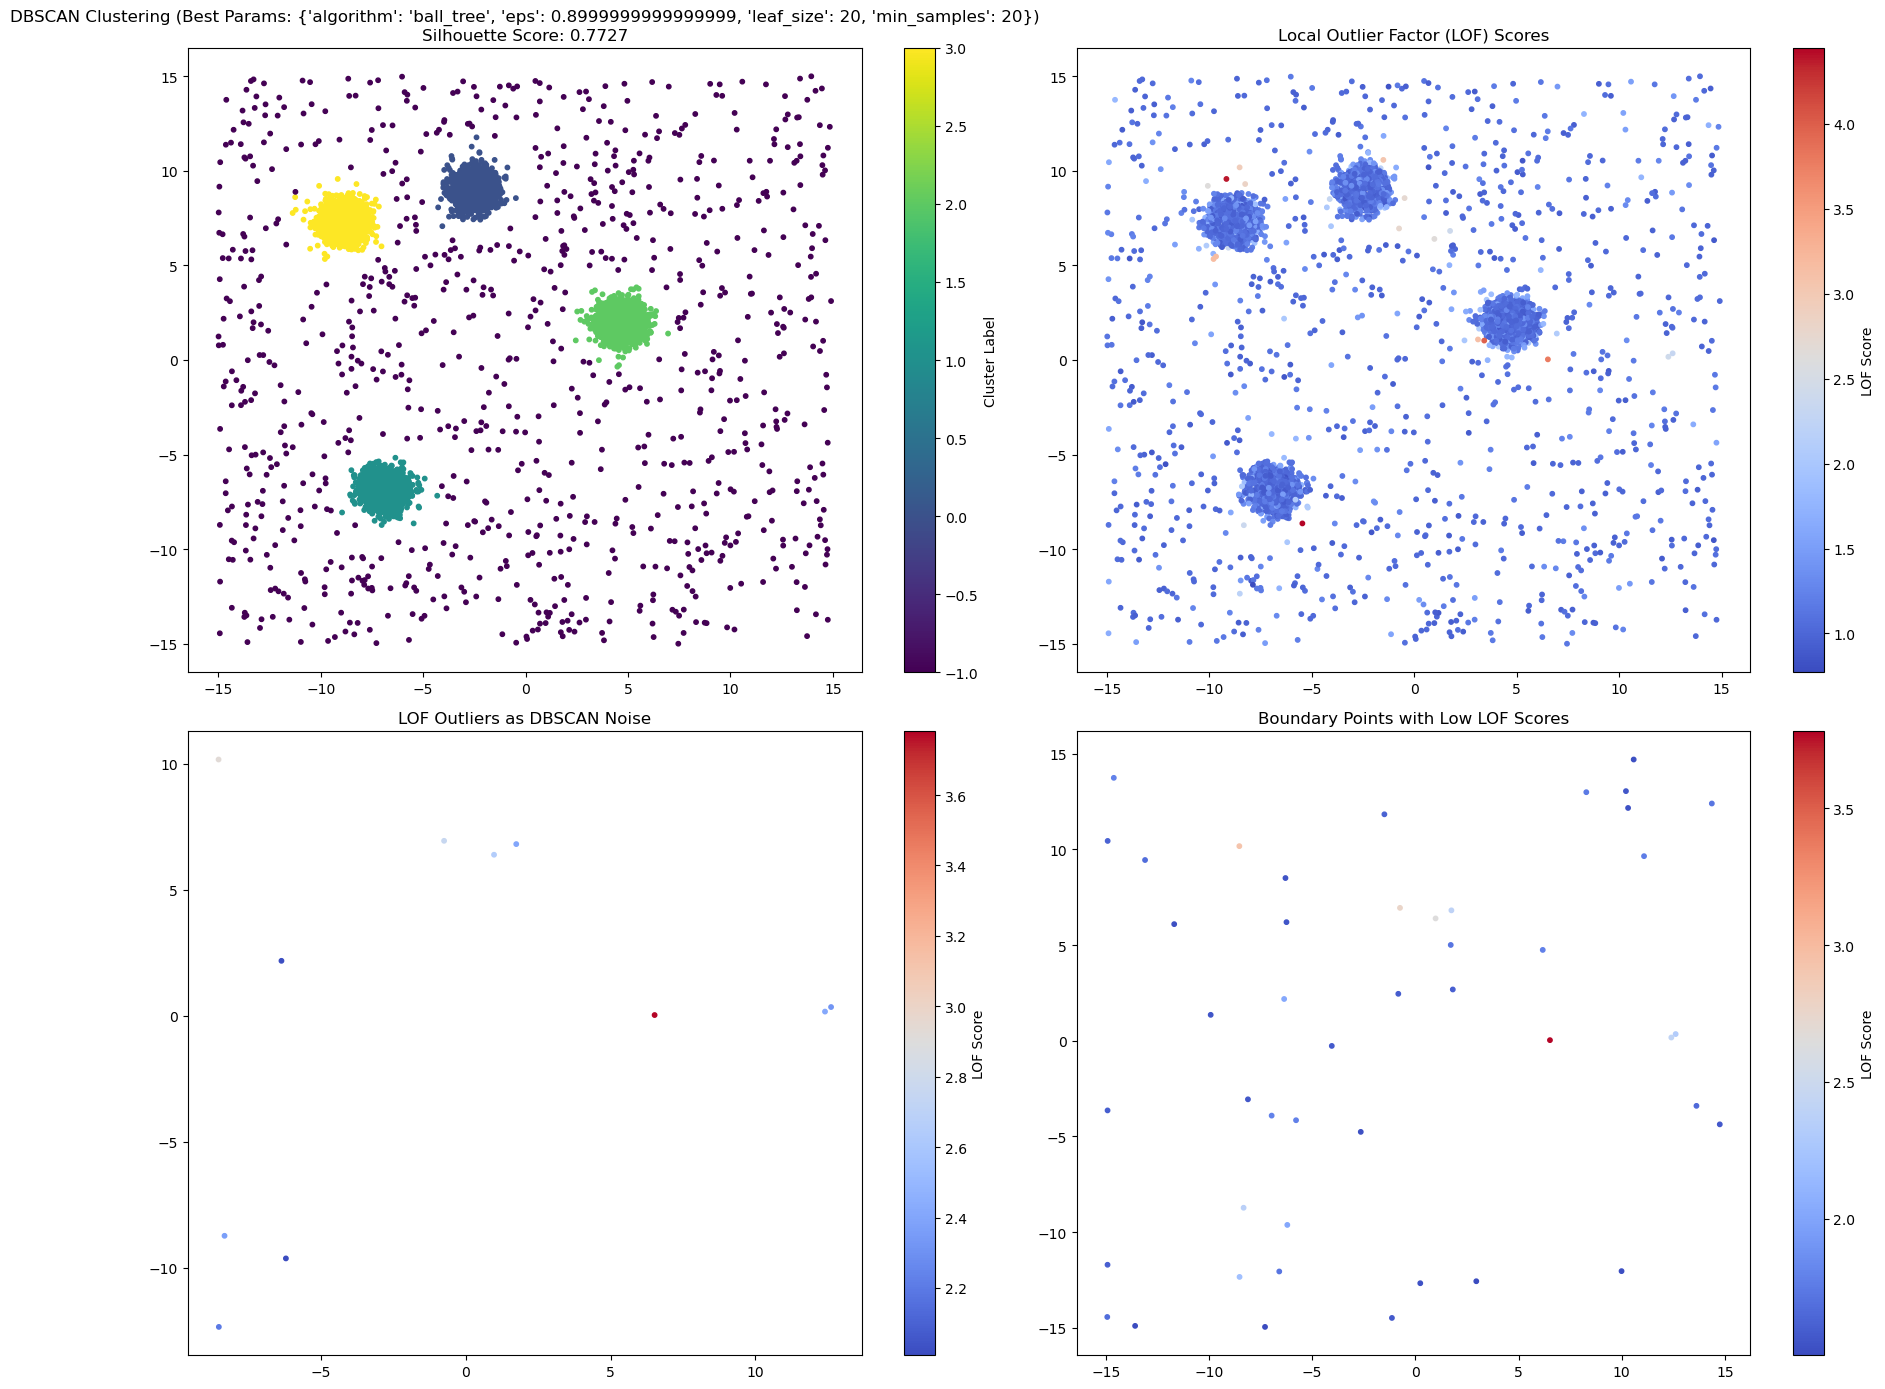

Best DBSCAN Parameters: {'algorithm': 'ball_tree', 'eps': 0.8999999999999999, 'leaf_size': 20, 'min_samples': 20}
Best Silhouette Score: 0.7727362783335437


In [13]:
# Plot side by side: DBSCAN clustering, LOF, and LOF without DBSCAN clusters
fig, ax = plt.subplots(2, 2, figsize=(18, 14))

# Top Left: DBSCAN plot
scatter_dbscan = ax[0, 0].scatter(x[:, 0], x[:, 1], c=dbscan_labels, cmap='viridis', s=10)
ax[0, 0].set_title(f"DBSCAN Clustering (Best Params: {best_params_dbscan})\nSilhouette Score: {best_score_dbscan:.4f}")
fig.colorbar(scatter_dbscan, ax=ax[0, 0], label="Cluster Label")

# Top Right: LOF plot
scatter_lof = ax[0, 1].scatter(x[:, 0], x[:, 1], c=lof_scores, cmap='coolwarm', s=10)
ax[0, 1].set_title("Local Outlier Factor (LOF) Scores")
fig.colorbar(scatter_lof, ax=ax[0, 1], label="LOF Score")

# Bottom Left: Points excluded by LOF but outliers in DBSCAN
scatter_lof_excluded_dbscan = ax[1, 0].scatter(lof_outliers_as_dbscan_noise[:, 0], 
                                                lof_outliers_as_dbscan_noise[:, 1], 
                                                c=lof_scores[(dbscan_labels == -1) & (lof_labels == -1)], 
                                                cmap='coolwarm', s=10)
ax[1, 0].set_title("LOF Outliers as DBSCAN Noise")
fig.colorbar(scatter_lof_excluded_dbscan, ax=ax[1, 0], label="LOF Score")

# Bottom Right: Boundary points from DBSCAN that have low LOF scores
scatter_lof_filtered = ax[1, 1].scatter(non_cluster_points[high_lof_scores_mask_non_cluster, 0], 
                                         non_cluster_points[high_lof_scores_mask_non_cluster, 1], 
                                         c=lof_scores_non_cluster[high_lof_scores_mask_non_cluster], 
                                         cmap='coolwarm', s=10)
ax[1, 1].set_title("Boundary Points with Low LOF Scores")
fig.colorbar(scatter_lof_filtered, ax=ax[1, 1], label="LOF Score")

plt.tight_layout()
plt.show()

# Print additional information
print(f"Best DBSCAN Parameters: {best_params_dbscan}")
print(f"Best Silhouette Score: {best_score_dbscan}")


### Encoding classes and methods

Functions and classes that encode the data in information constant fashion.

In [14]:
def one_hot_encode_features(train, features):
    # Convert the specified columns to string type
    for feature in features:
        train[feature] = train[feature].apply(lambda x: x if x else np.nan).astype(str)

    # Initialize OneHotEncoder with options
    encoder = OneHotEncoder(drop=None, sparse_output=False) 

    # Fit and transform the specified categorical columns
    encoded_cols = encoder.fit_transform(train[features])

    # Convert the result to a DataFrame with prefixed column names
    encoded_df = pd.DataFrame(encoded_cols, columns=['oh_' + col for col in encoder.get_feature_names_out(features)], index=train.index)

    # Concatenate with the original DataFrame and dropping the original columns
    df_encoded = pd.concat([train.drop(columns=features), encoded_df], axis=1)

    # Get the list of new column names
    new_column_names = list(encoded_df.columns)
w
    return df_encoded, new_column_names


### Imputiation classes and functions

Functions and classes that assist in the imputation of missing data.

#### GridSearchImputer

This class allows for the use of supervised and unsupervised models, it's main purpose is to impute data using supervised or unsupervised data

In [38]:
class GridSearchImputer:
    """
    A grid search-based imputation class for finding optimal hyperparameters 
    to impute missing data using supervised or unsupervised methods.

    Parameters:
    ----------
    imputer_dict : dict
        Dictionary containing:
          - `param_grid`: Dictionary of hyperparameters for grid search.
          - `cost_args`: Dictionary containing:
              - `call`: Callable cost function.
              - `kwargs`: Additional arguments for the cost function.
    imputer : object, optional
        An imputer or algorithm instance (e.g., KNNImputer, RandomForestRegressor).
    task : str, optional, default="regression"
        Specifies the type of task ('regression' or 'classification').

    Attributes:
    ----------
    param_grid : dict
        Dictionary of hyperparameters for grid search.
    cost_function : callable
        The cost function used to evaluate imputation performance.
    best_score : float
        The best score achieved during grid search.
    best_params : dict
        The hyperparameters corresponding to the best score.
    best_imputer : object
        The best imputer model after grid search.
    results : list
        List of results containing parameter combinations and their respective scores.

    Notes:
    -----
    - For regression tasks, the default cost function is `mean_squared_error`.
    - For classification tasks, the default cost function is `accuracy_score`.
    """
    def __init__(self, imputer_dict, imputer=None, task="regression"):
        # Extract param_grid and cost_args from the imputer_dict
        self.param_grid = imputer_dict.get('param_grid', {})
        self.cost_args = imputer_dict.get('cost_args', {})
        
        # Initialize attributes
        self.imputer = imputer
        self.task = task.lower()
        self.best_score = float('inf')
        self.best_params = None
        self.best_imputer = None
        self.results = []
        
        # Validate hyperparameters and cost function arguments
        self.validate_imputer_params(self.param_grid)  
        self.validate_cost_function(self.cost_args)  
    
        # Initialize the cost function with provided arguments
        cost_callable = self.cost_args.get('call')
        cost_kwargs = self.cost_args.get('kwargs', {})
        
        if not callable(cost_callable):
            raise ValueError(f"The cost function must be callable. Got: {cost_callable}")
        
        # Store the name of the callable loss function before wrapping in a lambda
        self.cost_callable_name = cost_callable.__name__
        self.cost_function = lambda true, pred: cost_callable(true, pred, **cost_kwargs)
    
        # Summarize configurations
        print('\n' + "=" * 40)
        print("GridSearchImputer Initialized with Configurations")
        print("=" * 40)
        
        print(f"Task: {self.task}")
        print(f"Imputer: {self.imputer.__name__ if self.imputer else 'None'}")
        
        print("\nGrid Search Parameters:")
        for key, value in self.param_grid.items():
            print(f"\t{key}: {value}")
        
        print(f"\nCost Function: {cost_callable.__name__ if cost_callable else 'None'}")
        print("Cost Function Parameters:")
        for key, value in cost_kwargs.items():
            print(f"\t{key}: {value}")
        
        print("=" * 40 + '\n')

    def validate_imputer_params(self, params):
        """
        Validate hyperparameters against the imputer's expected parameters.
        
        Parameters:
        ----------
        params : dict
            Dictionary of hyperparameters to validate.
        
        Raises:
        ------
        ValueError:
            If any parameter is invalid for the specified imputer.
        """
        self.learning_type = self._classify_model(self.imputer())
        self._validate_constructor_params(params)

    def validate_cost_function(self, cost_args):
        """
        Validate the cost function and its arguments.

        Parameters:
        ----------
        cost_args : dict
            Dictionary containing `call` (cost function) and `kwargs` (arguments).
        
        Raises:
        ------
        ValueError:
            If the cost function is not callable or if invalid arguments are provided.
        """
        cost_callable = cost_args.get('call')
        cost_kwargs = cost_args.get('kwargs', {})
        
        if not callable(cost_callable):
            raise ValueError(f"The cost function must be callable. Got: {cost_callable}")

        cost_signature = inspect.signature(cost_callable)
        valid_args = cost_signature.parameters.keys()
        
        invalid_args = [arg for arg in cost_kwargs if arg not in valid_args]
        if invalid_args:
            raise ValueError(f"Invalid arguments for the cost function: {', '.join(invalid_args)}. "
                             f"Valid arguments are: {', '.join(valid_args)}.")

    def _classify_model(self, model):
        """
        Classify the model as supervised or unsupervised based on inheritance.

        Parameters:
        ----------
        model : object
            An instance of the model to classify.

        Returns:
        -------
        str
            'supervised' or 'unsupervised'.

        Raises:
        ------
        ValueError:
            If the model does not belong to a recognized class.
        """
        is_imputer = '_BaseImputer' in str(model.__class__.mro())
        is_estimator = 'BaseEstimator' in str(model.__class__.mro())
        is_ensemble = 'BaseEnsemble' in str(model.__class__.mro())

        if is_estimator and is_imputer:
            return "unsupervised"
        elif (is_estimator or is_ensemble) and not is_imputer:
            return "supervised"
        else:
            raise ValueError(f"The imputer {self.imputer} must be a subclass of either '_BaseImputer' (for unsupervised imputers) or 'BaseEstimator' (for supervised models).")

    def _validate_constructor_params(self, params):
        """
        Validate parameters against the imputer's constructor.

        Parameters:
        ----------
        params : dict
            Dictionary of parameters to validate.

        Raises:
        ------
        ValueError:
            If any parameter is not valid for the imputer's constructor.
        """
        constructor_signature = inspect.signature(self.imputer)
        constructor_params = constructor_signature.parameters.keys()

        invalid_params = [param for param in params if param not in constructor_params]
        if invalid_params:
            raise ValueError(f"Invalid parameters: {', '.join(invalid_params)}. "
                             f"Valid parameters are: {', '.join(constructor_params)}.")

    def make_missing(self, df, missing_percentage=0.2):
        """
        Introduce missing values into a dataframe or series by randomly selecting entries.

        Parameters:
        ----------
        df : pd.DataFrame or pd.Series
            Input data to introduce missing values.
        missing_percentage : float, optional, default=0.2
            Fraction of total entries to set as missing.

        Returns:
        -------
        tuple:
            - pd.DataFrame: Data with missing values.
            - np.ndarray: Row indices of missing values.
            - np.ndarray: Column indices of missing values.
        """
        df_with_missing = df.copy().astype('float64')
        n_rows, n_cols = df_with_missing.shape
        n_total_values = n_rows * n_cols
        n_missing = int(n_total_values * missing_percentage)

        missing_indices = np.random.choice(n_total_values, size=n_missing, replace=False)
        row_indices, col_indices = np.unravel_index(missing_indices, df_with_missing.shape)

        df_with_missing.iloc[row_indices, col_indices] = np.nan
        return df_with_missing, row_indices, col_indices

    def fit(self, X, missing_percentage=0.2, round_data=False, export_csv=None, y=None):
        """
        Fit the imputer by performing grid search to find the best hyperparameters.
    
        Parameters:
        ----------
        X : pd.DataFrame
            The input training data.
        missing_percentage : float, optional, default=0.2
            Percentage of data to set as missing during training.
        round_data : bool, optional, default=False
            Whether to round imputed values to integers.
        export_csv : str or None, optional
            Path to export results to a CSV file. If None, results are not exported.
        y : pd.DataFrame or None, optional
            Target values for supervised imputers (used during fitting).
    
        Notes:
        -----
        - For supervised imputers, the target `y` is required for training.
        - For unsupervised imputers, missing values are introduced in the data for evaluation.
        - Results of the grid search are stored in `self.results`.
        - The best model is stored in `self.best_imputer`.
    
        Raises:
        ------
        TypeError:
            If `X` contains non-numeric data.
        """
        # Ensure all data columns are numeric
        if not np.issubdtype(X[X.columns].dtypes.to_numpy().flatten()[0], np.number):
            raise TypeError("GridSearchImputer only supports numeric data.")
    
        # Perform grid search over all parameter combinations
        for params in ParameterGrid(self.param_grid):
            # Instantiate the imputer with current parameters
            imputer_instance = self.imputer(**params)
            
            # Print progress current parameters set
            print(f"Testing parameters: {params}")
            
            if self.learning_type == 'supervised':
                # Check if target `y` is provided
                if y is None:
                    raise ValueError("Target values `y` are required for supervised imputers.")
                
                # Split data into training and validation sets
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
                
                # Train and predict using the imputer
                imputer_instance.fit(X_train, y_train)
                imputed_values = imputer_instance.predict(X_val)
                true_values = y_val
            elif self.learning_type == 'unsupervised':
                # Introduce missing values for evaluation
                X_missing, missing_rows, missing_cols = self.make_missing(X, missing_percentage)
                imputed_data = imputer_instance.fit_transform(X_missing)
                
                # Extract true and imputed values for the same indices
                imputed_values = imputed_data[missing_rows, missing_cols]
                true_values = X.values[missing_rows, missing_cols]
    
                # Flatten the extracted values for evaluation
                imputed_values = np.array(imputed_values).flatten()
                true_values = np.array(true_values).flatten()
            else:
                raise ValueError("Unsupported learning type. Expected 'supervised' or 'unsupervised'.")
    
            # Optionally round the imputed values
            if round_data:
                imputed_values = np.round(imputed_values).astype('int64')
    
            # Compute the loss metric
            loss = self.cost_function(true_values, imputed_values)
    
            # Update the best model based on the lowest loss
            if loss < self.best_score:
                self.best_score = loss
                self.best_params = params
                self.best_imputer = imputer_instance
    
                # Log the results for analysis
                self.results.append({
                    "Parameters": params,
                    "Loss": loss,
                })
    
                # Print progress for the current parameter set
                print('\n' + ">" * 40)
                print("New best set of parameters found:\n")
                for key, value in params.items():
                    print(f"\t{key}: {value}")
                print(f"\nWith {self.cost_callable_name}: {np.round(loss, decimals=5)}")
                print(">" * 40 + '\n')
                
        # Export results to a CSV file if specified
        if export_csv:
            pd.DataFrame(self.results).to_csv(export_csv, index=False)
            print(f"Results exported to {export_csv}")


    def transform(self, X, round_data=False, y_fit=None, x_predict=None):
        """
        Impute missing values in the test data using the best found imputer.
    
        Parameters:
        ----------
        X : pd.DataFrame
            The dataset with missing values to be imputed.
        round_data : bool, optional, default=False
            If True, round imputed values to integers.
        y_fit : pd.DataFrame or None, optional
            Target values for supervised imputers (used during fitting).
        x_predict : pd.DataFrame or None, optional
            Input features for supervised imputers (used during prediction).
    
        Returns:
        -------
        np.ndarray:
            The imputed data.
    
        Raises:
        ------
        ValueError:
            If the `fit` method has not been called to determine the best imputer.
        """
        # Ensure the model has been fitted
        if self.best_params is None:
            raise ValueError("The model has not been fitted yet. Please call 'fit' first.")
    
        # Instantiate a fresh imputer with the best parameters
        imputer_instance = self.imputer(**self.best_params)
    
        if self.learning_type == 'supervised':
            # Check that target and prediction data are provided
            if y_fit is None or x_predict is None:
                raise ValueError("Both `y_fit` and `x_predict` are required for supervised imputers.")
    
            imputer_instance.fit(X, y_fit)  # Fit the imputer
            imputed_data = imputer_instance.predict(x_predict)  # Predict and fill missing values
        elif self.learning_type == 'unsupervised':
            imputed_data = imputer_instance.fit_transform(X)  # Fit and transform (impute values directly)
        else:
            raise ValueError("Unsupported learning type. Expected 'supervised' or 'unsupervised'.")
    
        # Optionally round the imputed data
        if round_data:
            imputed_data = np.round(imputed_data).astype('int64')
    
        return imputed_data


In [42]:
from sklearn.metrics import root_mean_squared_error
# Example usage

# Sample data
X = pd.DataFrame({
    'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'B': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
})

# Sample target with missing values
y = pd.DataFrame({
    'C': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    'D': [9, 10, 11, np.nan, 13, 14, 15, np.nan, 17, 18]
})

# Define the parameter grid for RandomForestRegressor
imputer_dict = \
    {
    'param_grid' : \
    {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'cost_args' : \
    {
        'call' : root_mean_squared_error,
        'kwargs' : {
        
            }
    }   
}
# Initialize the GridSearchImputer
grid_imputer = GridSearchImputer(imputer_dict, imputer=RandomForestRegressor, task='regression')

# Fit the imputer using the training data
grid_imputer.fit(X, y=y['C'], round_data=True)

# Select the rows where y['D'] is missing
x_predict = X[y['D'].isna()]  # Select corresponding rows in X where y['D'] is NaN

# Transform the test data using the best imputer found, and impute the missing values in y['D']
imputed_data = grid_imputer.transform(X, y_fit=y['C'], x_predict=x_predict, round_data=True)

# Output results
print("\nBest RandomForestRegressor parameters:")
print(grid_imputer.best_params)
print(f"Best {imputer_dict['cost_args']['call'].__name__}: {grid_imputer.best_score}")
print("\nImputed Data:\n", imputed_data)



GridSearchImputer Initialized with Configurations
Task: regression
Imputer: RandomForestRegressor

Grid Search Parameters:
	n_estimators: [10, 50, 100]
	max_depth: [None, 5, 10]
	min_samples_split: [2, 5]
	min_samples_leaf: [1, 2]

Cost Function: root_mean_squared_error
Cost Function Parameters:

Testing parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
New best set of parameters found:

	max_depth: None
	min_samples_leaf: 1
	min_samples_split: 2
	n_estimators: 10

With root_mean_squared_error: 0.0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Testing parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Testing parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Testing parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Testing parameters: {'max_depth': None, 

In [43]:
from sklearn.metrics import mean_absolute_error
# Sample data
X = pd.DataFrame({
    'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'B': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
})

# Sample target with missing values
y = pd.DataFrame({
    'C': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    'D': [np.nan, 10, 11, np.nan, 13, np.nan, 15, np.nan, 17, np.nan]
})

# Define the parameter grid for KNNImputer
imputer_dict = \
    {
    'param_grid' : {
        'n_neighbors': np.arange(1,20,1),  # Number of neighbors for KNN
        'weights': ['uniform', 'distance']
    },
    'cost_args' : \
    {
        'call' : mean_absolute_error,
        'kwargs' : {

            }
    }   
}
# Initialize the GridSearchImputer with KNNImputer
grid_imputer = GridSearchImputer(imputer_dict, imputer=KNNImputer, task='regression')

# Fit the imputer using the training data
grid_imputer.fit(X, missing_percentage=0.2, round_data=True)

# Transform the test data using the best imputer found, and impute the missing values in y['D']
imputed_data = grid_imputer.transform(y, round_data=True, x_predict=x_predict)

# Output results
print("\nBest KNNImputer parameters:")
print(grid_imputer.best_params)
print(f"Best {imputer_dict['cost_args']['call'].__name__}: {grid_imputer.best_score}")
print("\nImputed Data:\n", imputed_data)




GridSearchImputer Initialized with Configurations
Task: regression
Imputer: KNNImputer

Grid Search Parameters:
	n_neighbors: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
	weights: ['uniform', 'distance']

Cost Function: mean_absolute_error
Cost Function Parameters:

Testing parameters: {'n_neighbors': 1, 'weights': 'uniform'}

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
New best set of parameters found:

	n_neighbors: 1
	weights: uniform

With mean_absolute_error: 2.75
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Testing parameters: {'n_neighbors': 1, 'weights': 'distance'}
Testing parameters: {'n_neighbors': 2, 'weights': 'uniform'}
Testing parameters: {'n_neighbors': 2, 'weights': 'distance'}
Testing parameters: {'n_neighbors': 3, 'weights': 'uniform'}

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
New best set of parameters found:

	n_neighbors: 3
	weights: uniform

With mean_absolute_error: 1.0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Testing parameters: {'n_neighbors': 3, 'w

## Data Ingestion

Current data ingestion mechanism.

In [17]:
# Data is ingested from the working directory, with the index set to col_0 and dtypes applied directly
with open('../data/dtypes.json', 'r') as file:
    train = pd.read_csv('../data/preproc_train.csv', index_col=0, dtype=json.load(file), low_memory=True)

In [18]:
# Data is ingested from the working directory, with the index set to col_0 and dtypes applied directly
with open('../data/dtypes.json', 'r') as file:
    test = pd.read_csv('../data/preproc_test.csv', index_col=0, dtype=json.load(file), low_memory=True)

In [ ]:
summarize_missing_information(no_missing)